## 1.Importation des librairies et Configuration initiale

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning - Outils & Métriques
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, precision_score, recall_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
PROCESSOR_PATH = "processors/"

print(f"📅 Démarrage : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)
print(" 💾 SAUVEGARDE DU PIPELINE DE PREPROCESSING ")
print("="*80)

📅 Démarrage : 2025-11-23 11:33:27
 💾 SAUVEGARDE DU PIPELINE DE PREPROCESSING 


## 2.Chargement et Vérification des Données Prétraitées

In [2]:
# -------------------------------------------------------------------------
# 1. Charger tous les objets sauvegardés
# -------------------------------------------------------------------------
with open("processors/feature_label_encoders.pkl", "rb") as f:
    label_encoders_loaded = pickle.load(f)

with open("processors/target_label_encoder.pkl", "rb") as f:
    le_target_loaded = pickle.load(f)

with open("processors/robust_scaler.pkl", "rb") as f:
    scaler_loaded = pickle.load(f)

with open("processors/features_config.pkl", "rb") as f:
    config_loaded = pickle.load(f)

with open("processors/preprocessed_data.pkl", "rb") as f:
    data_loaded = pickle.load(f)

print("✓ Preprocessors chargés : LabelEncoders, Scaler, Config, X/Y preprocessed.")

# -------------------------------------------------------------------------
# 2. Extraire les datasets prétraités
# -------------------------------------------------------------------------
X_train_scaled_loaded = data_loaded["X_train_scaled"]
X_test_scaled_loaded = data_loaded["X_test_scaled"]
y_train_loaded = data_loaded["y_train"]
y_test_loaded = data_loaded["y_test"]
df_train = pd.DataFrame(
    X_train_scaled_loaded,
    columns=config_loaded["final_feature_order"]
)

df_test = pd.DataFrame(
    X_test_scaled_loaded,
    columns=config_loaded["final_feature_order"]
)

print("\n" + "-"*90)
print("   APERÇU DES DONNÉES PRÉTRAITÉES (X_train_scaled)")
print("-"*90)

display(df_train.head())

print("\nShape :", df_train.shape)


print("\n" + "-"*90)
print("   APERÇU DES FEATURES (liste finale utilisée par le modèle)")
print("-"*90)

for i, feature in enumerate(config_loaded["final_feature_order"]):
    print(f"{i+1:2d}. {feature}")

✓ Preprocessors chargés : LabelEncoders, Scaler, Config, X/Y preprocessed.

------------------------------------------------------------------------------------------
   APERÇU DES DONNÉES PRÉTRAITÉES (X_train_scaled)
------------------------------------------------------------------------------------------


,mocodes,premis_cd,location,weapon_used_cd,vict_age,Day,area,crm_risk,Month,vict_descent,status,Weekday,Hour_Bin,Year,vict_sex_F,vict_sex_M,vict_sex_X
0,-0.306487,-0.2550,-0.320911,0.0,-0.939394,-0.933333,0.2,0.0,-0.6,0.363636,0.0,0.0,-0.5,-1.0,0.0,0.0,1.0
1,-0.306487,-0.2550,0.616180,0.0,-0.939394,-0.600000,0.1,0.0,-0.6,0.363636,0.0,-0.5,0.5,-1.0,0.0,0.0,1.0
2,-0.306487,-0.2550,0.886653,0.0,-0.939394,-0.666667,0.3,0.0,-0.8,0.363636,0.0,0.5,0.0,0.0,0.0,0.0,1.0
3,-0.401136,-0.2375,0.632514,0.0,-0.212121,-0.866667,0.8,1.0,-0.6,-0.454545,-2.0,0.5,-0.5,0.0,1.0,0.0,0.0
4,-0.426793,0.5075,0.421419,0.0,0.000000,0.933333,-0.4,0.0,-0.4,0.545455,-2.0,0.5,0.0,-1.0,0.0,1.0,0.0



Shape : (319110, 17)

------------------------------------------------------------------------------------------
   APERÇU DES FEATURES (liste finale utilisée par le modèle)
------------------------------------------------------------------------------------------
 1. mocodes
 2. premis_cd
 3. location
 4. weapon_used_cd
 5. vict_age
 6. Day
 7. area
 8. crm_risk
 9. Month
10. vict_descent
11. status
12. Weekday
13. Hour_Bin
14. Year
15. vict_sex_F
16. vict_sex_M
17. vict_sex_X


## 3.Définition des Modèles (Bagging & Boosting)

In [3]:
# Dictionnaire des modèles
models = {
    "RandomForest (Bagging)": RandomForestClassifier(
        n_estimators=150,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    
    "XGBoost1": XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42
    ),
    
    "LightGBM1": LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
    
    "CatBoost1": CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=6,
        verbose=0, # Silencieux
        random_state=42,
        allow_writing_files=False
    )
}

## 4. Entraînement, Évaluation et Comparaison des Modèles


Données prêtes pour l'entraînement : (319110, 17) features

🚀 DÉMARRAGE DE L'ÉVALUATION COMPARATIVE


########################################
🔍 MODÈLE : RandomForest (Bagging)
########################################
✓ Temps d'entraînement : 18.73 secondes

=== RÉSULTATS : RandomForest (Bagging) ===
Accuracy              : 0.8898
F1-score (weighted)   : 0.8943
AUC ROC (macro OVR)   : 0.9882

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.61      0.93      0.74      3818
           1       0.95      0.81      0.87      8866
           2       0.41      0.63      0.50      1669
           3       0.99      0.95      0.97     35768
           4       0.90      0.93      0.91     22336
           5       0.78      0.61      0.69      6484
           6       0.31      0.51      0.39       837

    accuracy                           0.89     79778
   macro avg       0.71      0.77      0.72     79778
weighted avg       0.91      0.

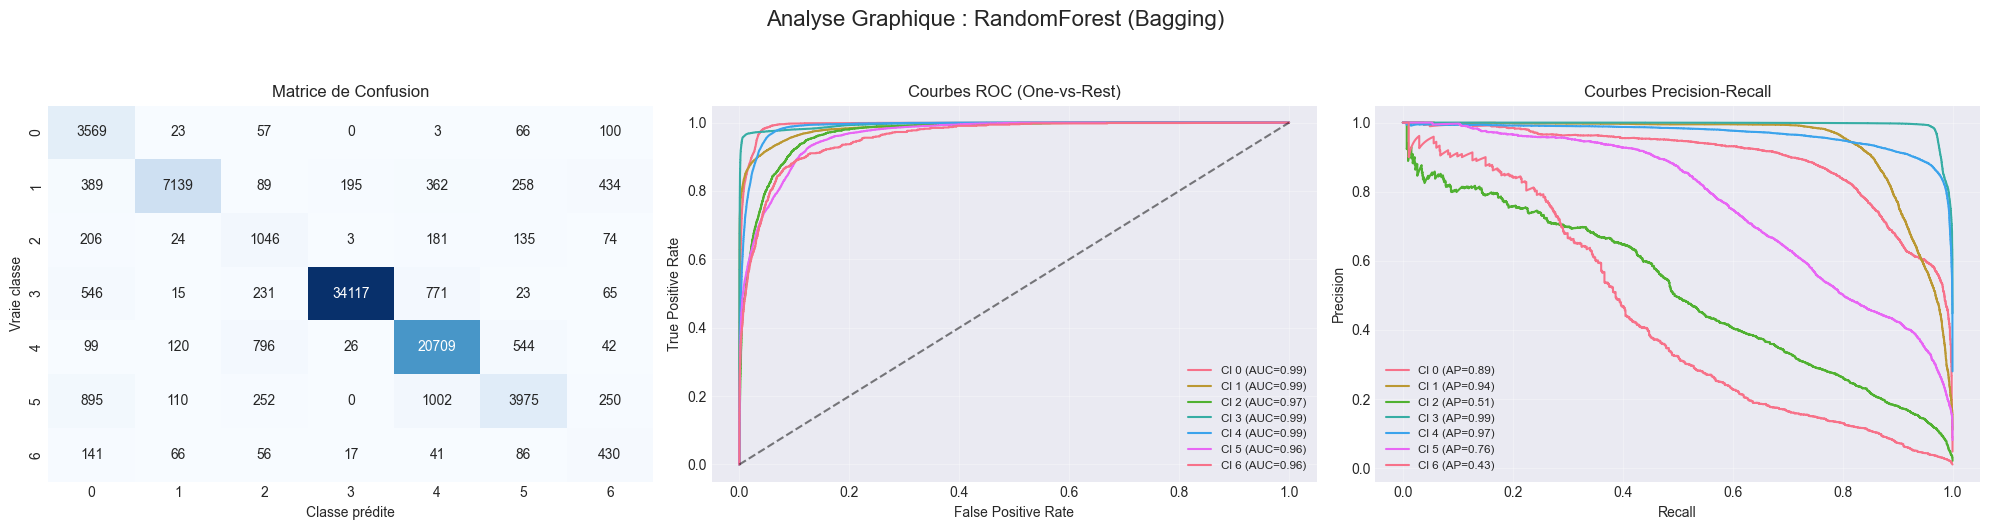



########################################
🔍 MODÈLE : XGBoost1
########################################
✓ Temps d'entraînement : 13.35 secondes

=== RÉSULTATS : XGBoost1 ===
Accuracy              : 0.9256
F1-score (weighted)   : 0.9233
AUC ROC (macro OVR)   : 0.9930

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3818
           1       0.94      0.89      0.91      8866
           2       0.73      0.51      0.60      1669
           3       0.99      0.98      0.98     35768
           4       0.90      0.97      0.93     22336
           5       0.76      0.73      0.75      6484
           6       0.67      0.35      0.46       837

    accuracy                           0.93     79778
   macro avg       0.83      0.76      0.79     79778
weighted avg       0.92      0.93      0.92     79778



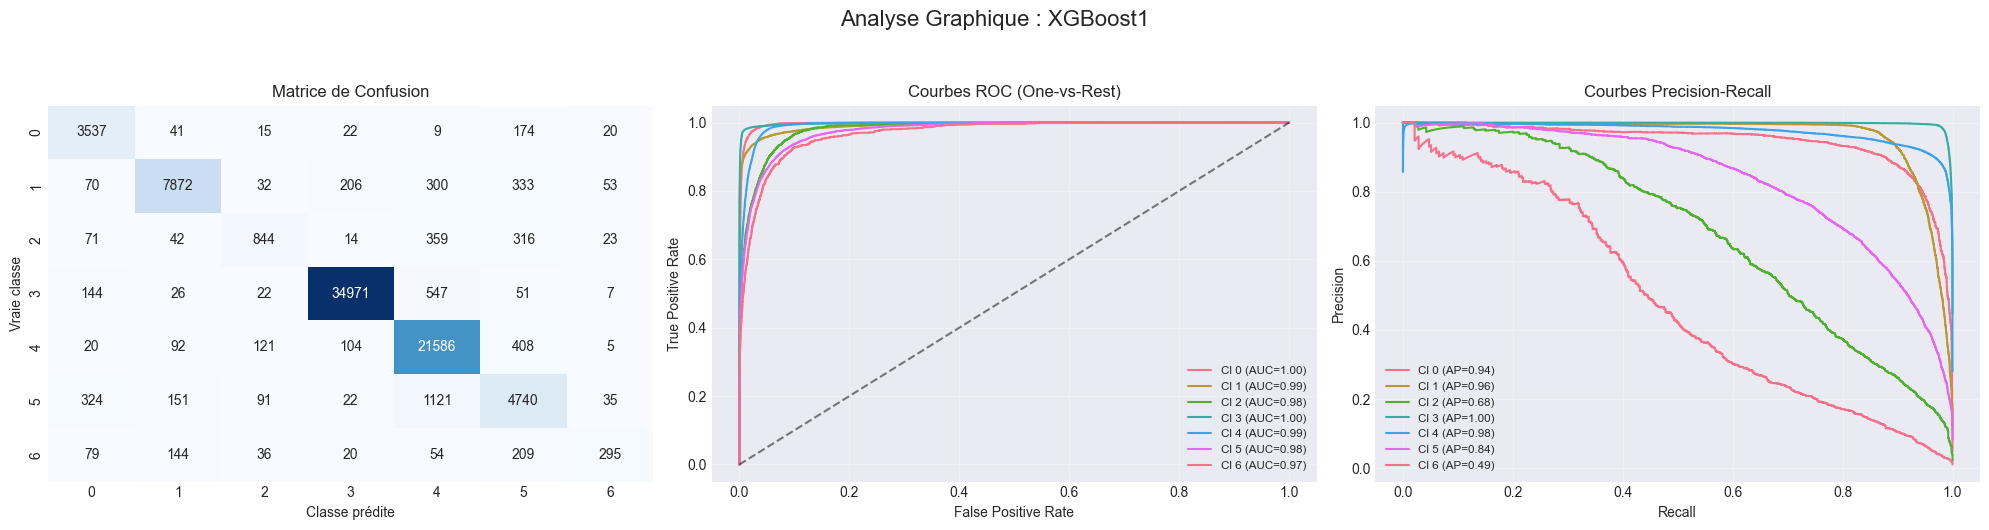



########################################
🔍 MODÈLE : LightGBM1
########################################
✓ Temps d'entraînement : 10.10 secondes

=== RÉSULTATS : LightGBM1 ===
Accuracy              : 0.9062
F1-score (weighted)   : 0.9130
AUC ROC (macro OVR)   : 0.9919

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      3818
           1       0.96      0.88      0.91      8866
           2       0.43      0.73      0.54      1669
           3       0.99      0.97      0.98     35768
           4       0.93      0.89      0.91     22336
           5       0.74      0.70      0.72      6484
           6       0.27      0.66      0.38       837

    accuracy                           0.91     79778
   macro avg       0.74      0.82      0.76     79778
weighted avg       0.92      0.91      0.91     79778



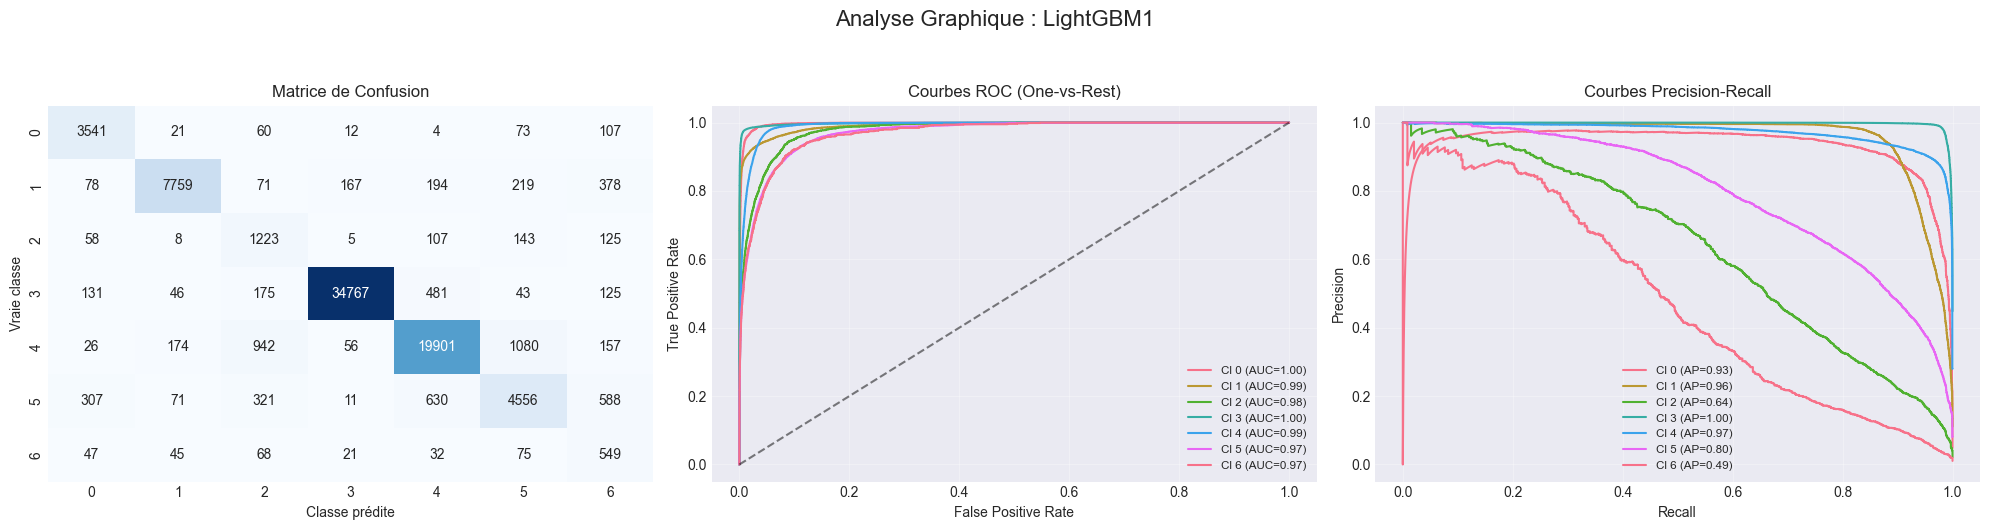



########################################
🔍 MODÈLE : CatBoost1
########################################
✓ Temps d'entraînement : 15.55 secondes

=== RÉSULTATS : CatBoost1 ===
Accuracy              : 0.9124
F1-score (weighted)   : 0.9086
AUC ROC (macro OVR)   : 0.9901

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      3818
           1       0.92      0.86      0.89      8866
           2       0.72      0.38      0.50      1669
           3       0.99      0.97      0.98     35768
           4       0.88      0.97      0.92     22336
           5       0.75      0.68      0.72      6484
           6       0.67      0.31      0.42       837

    accuracy                           0.91     79778
   macro avg       0.81      0.73      0.75     79778
weighted avg       0.91      0.91      0.91     79778



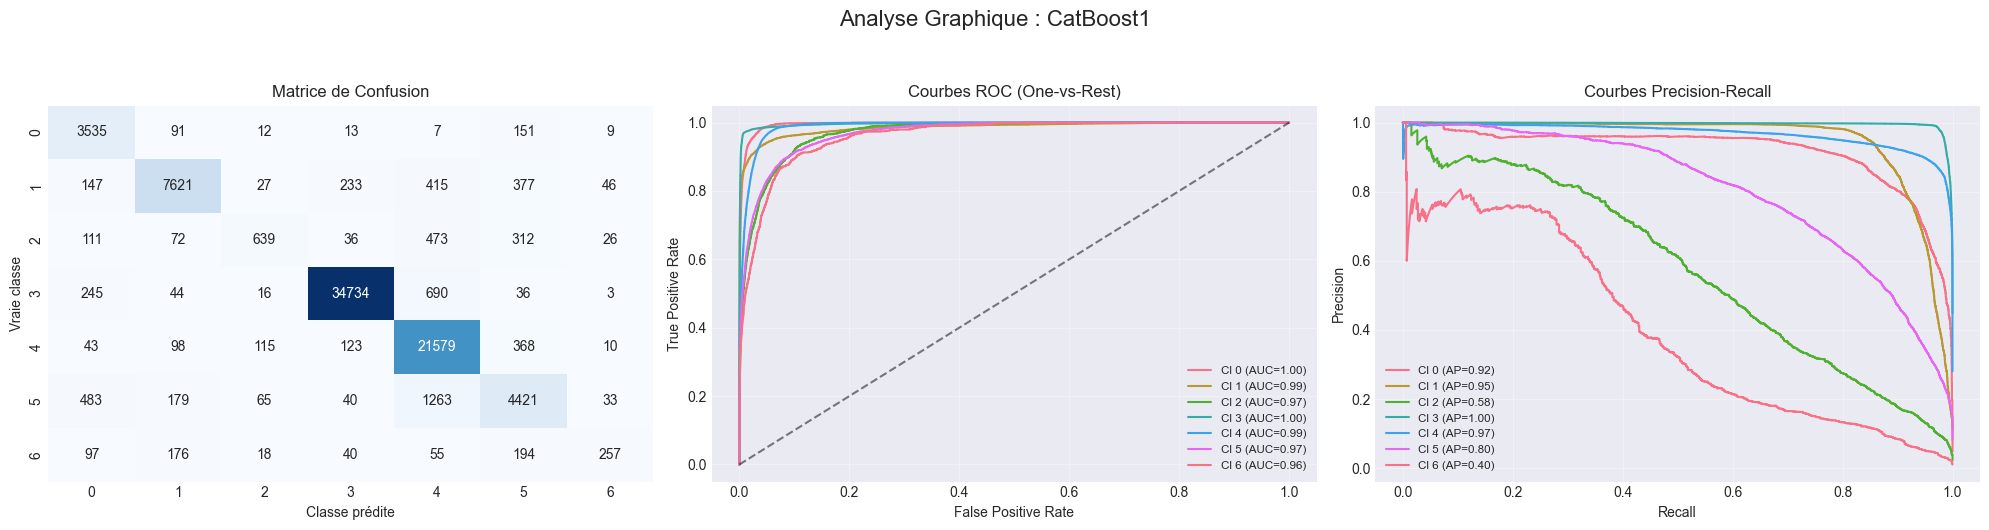


🏆 TABLEAU RÉCAPITULATIF GLOBAL (Trié par F1-Score)


,Modèle,Tuned,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps (s)
1,XGBoost1,Non,0.925631,0.924016,0.925631,0.923312,0.993013,13.3
2,LightGBM1,Non,0.906215,0.924071,0.906215,0.912970,0.991852,10.1
3,CatBoost1,Non,0.912357,0.910857,0.912357,0.908611,0.990133,15.5
0,RandomForest (Bagging),Non,0.889782,0.906986,0.889782,0.894279,0.988168,18.7


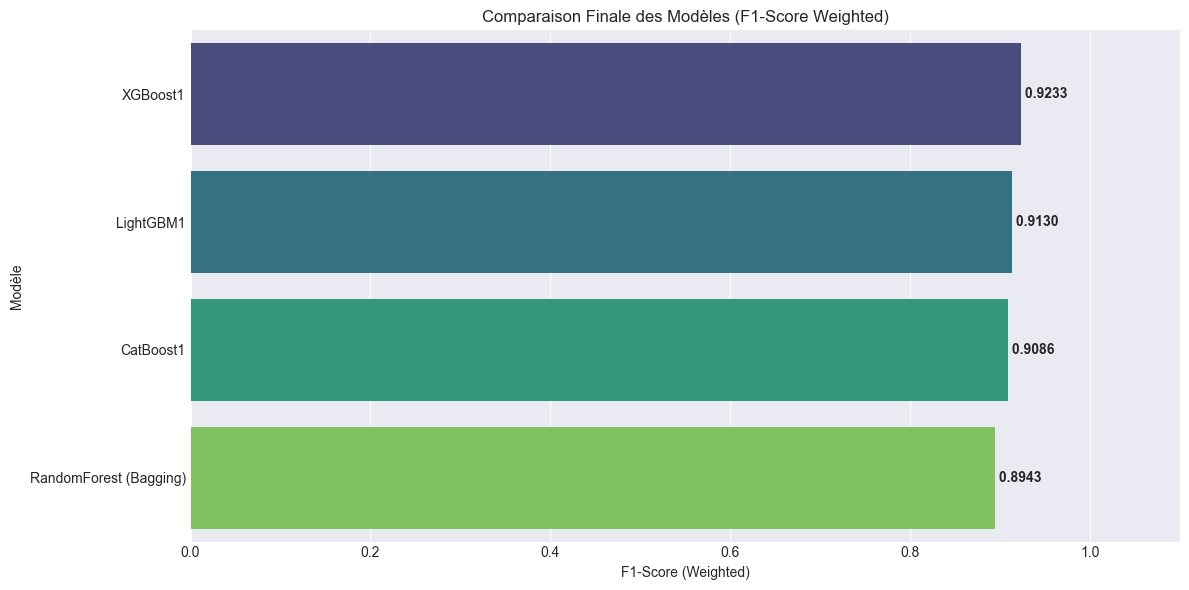

In [4]:
# ============================================================
# 5. PRÉPARATION DES VARIABLES POUR L'ENTRAÎNEMENT
# ============================================================
# On utilise les variables chargées depuis le pickle
X_train = X_train_scaled_loaded
y_train = y_train_loaded
X_test = X_test_scaled_loaded
y_test = y_test_loaded

print(f"\nDonnées prêtes pour l'entraînement : {X_train.shape} features")

# ============================================================
# 6. BOUCLE D'ENTRAÎNEMENT ET ÉVALUATION DÉTAILLÉE
# ============================================================
results_df = []

print("\n" + "="*80)
print("🚀 DÉMARRAGE DE L'ÉVALUATION COMPARATIVE")
print("="*80)

for name, model in models.items():
    print(f"\n\n{'#'*40}")
    print(f"🔍 MODÈLE : {name}")
    print(f"{'#'*40}")
    
    # ------------------------------------------------------------
    # A. Entraînement avec mesure du temps
    # ------------------------------------------------------------
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print(f"✓ Temps d'entraînement : {elapsed_time:.2f} secondes")
    
    # ------------------------------------------------------------
    # B. Prédictions
    # ------------------------------------------------------------
    y_pred = model.predict(X_test)
    
    # Gestion des probabilités pour ROC-AUC
    try:
        y_pred_proba = model.predict_proba(X_test)
    except AttributeError:
        print(f"⚠️ Le modèle {name} ne supporte pas predict_proba.")
        y_pred_proba = None

    # ------------------------------------------------------------
    # C. Calcul des Métriques
    # ------------------------------------------------------------
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    roc_auc_val = 0
    if y_pred_proba is not None:
        try:
            # multi_class='ovr' pour One-Vs-Rest
            roc_auc_val = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        except Exception as e:
            print(f"⚠️ Erreur calcul AUC: {e}")

    # ------------------------------------------------------------
    # Stockage pour le tableau final (AJOUT DE LA COLONNE TUNED)
    # ------------------------------------------------------------
    results_df.append({
        "Modèle": name,
        "Tuned": "Non",  # <--- Nouvelle colonne (Par défaut "Non" pour cette boucle)
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc_val,
        "Temps (s)": elapsed_time
    })

    # Affichage Console des scores
    print(f"\n=== RÉSULTATS : {name} ===")
    print(f"Accuracy              : {acc:.4f}")
    print(f"F1-score (weighted)   : {f1:.4f}")
    print(f"AUC ROC (macro OVR)   : {roc_auc_val:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    # ------------------------------------------------------------
    # D. VISUALISATIONS (3 Graphiques par modèle)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Analyse Graphique : {name}", fontsize=16, y=1.05)

    # 1. Matrice de Confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Matrice de Confusion')
    axes[0].set_xlabel('Classe prédite')
    axes[0].set_ylabel('Vraie classe')

    if y_pred_proba is not None:
        n_classes = y_pred_proba.shape[1]
        
        # 2. Courbes ROC (One-vs-Rest)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
            auc_score_class = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, label=f'Cl {i} (AUC={auc_score_class:.2f})')
        
        axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[1].set_title('Courbes ROC (One-vs-Rest)')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(fontsize='small')
        axes[1].grid(alpha=0.3)

        # 3. Courbes Precision-Recall
        for i in range(n_classes):
            precision_curve, recall_curve, _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
            ap = average_precision_score(y_test == i, y_pred_proba[:, i])
            axes[2].plot(recall_curve, precision_curve, label=f'Cl {i} (AP={ap:.2f})')

        axes[2].set_title('Courbes Precision-Recall')
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].legend(fontsize='small')
        axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================
# 7. SYNTHÈSE FINALE (Avec Tri F1-Score + Couleurs)
# ============================================================
print("\n" + "="*80)
print("🏆 TABLEAU RÉCAPITULATIF GLOBAL (Trié par F1-Score)")
print("="*80)

# 1. Création et organisation du DataFrame
# On s'assure que les colonnes sont dans un ordre logique
cols_order = ["Modèle", "Tuned", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Temps (s)"]
df_scores = pd.DataFrame(results_df)

# On reordonne si toutes les colonnes existent, sinon on garde tel quel
if set(cols_order).issubset(df_scores.columns):
    df_scores = df_scores[cols_order]

# 2. Tri par F1-Score décroissant (Le meilleur en haut)
df_scores = df_scores.sort_values(by="F1-Score", ascending=False)

# 3. APPLICATION DU STYLE (COULEURS)
# Définition des colonnes de métriques (Plus haut = Mieux) -> Vert
metrics_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

# Création de l'objet stylisé
styled_df = (df_scores.style
    # Formatage des nombres (4 décimales pour les scores, 1 pour le temps)
    .format({col: "{:.4f}" for col in metrics_cols})
    .format({"Temps (s)": "{:.1f}"})
    
    # Couleur VERTE pour les métriques (Foncé = Meilleur)
    .background_gradient(subset=metrics_cols, cmap="Greens")
    
    # Couleur ROUGE pour le temps (Foncé = Plus lent/Mauvais)
    .background_gradient(subset=["Temps (s)"], cmap="OrRd")
    
    # Titre du tableau (Optionnel, purement esthétique dans certains notebooks)
    .set_caption("Classement des modèles par F1-Score")
)

# Affichage du tableau coloré
display(styled_df)

# 4. Graphique comparatif final basé sur le F1-Score
plt.figure(figsize=(12, 6))
# On utilise une palette "viridis" qui va du jaune au violet pour bien distinguer
sns.barplot(x="F1-Score", y="Modèle", data=df_scores, palette="viridis")

# Ajout des labels de valeurs sur les barres
for index, value in enumerate(df_scores["F1-Score"]):
    plt.text(value, index, f' {value:.4f}', va='center', fontsize=10, fontweight='bold')

plt.title("Comparaison Finale des Modèles (F1-Score Weighted)")
plt.xlim(0.0, 1.1) # Un peu plus que 1 pour laisser de la place au texte
plt.xlabel("F1-Score (Weighted)")
plt.tight_layout()
plt.show()

## 5. Stratégie de Stacking et Mise à jour du Benchmark


🏗️ 1. CONSTRUCTION ET ÉVALUATION DU STACKING BASELINE
⏳ Entraînement du Stacking Baseline en cours...
✓ Temps d'entraînement : 191.21 secondes

=== RÉSULTATS : STACKING BASELINE ===
Accuracy              : 0.9284
Precision (weighted)  : 0.9274
Recall (weighted)     : 0.9284
F1-score (weighted)   : 0.9273  <-- CRITÈRE PRINCIPAL
AUC ROC (macro OVR)   : 0.9926

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3818
           1       0.94      0.90      0.92      8866
           2       0.69      0.58      0.63      1669
           3       0.99      0.98      0.98     35768
           4       0.91      0.96      0.93     22336
           5       0.75      0.76      0.75      6484
           6       0.61      0.39      0.48       837

    accuracy                           0.93     79778
   macro avg       0.82      0.78      0.80     79778
weighted avg       0.93      0.93      0.93     79778



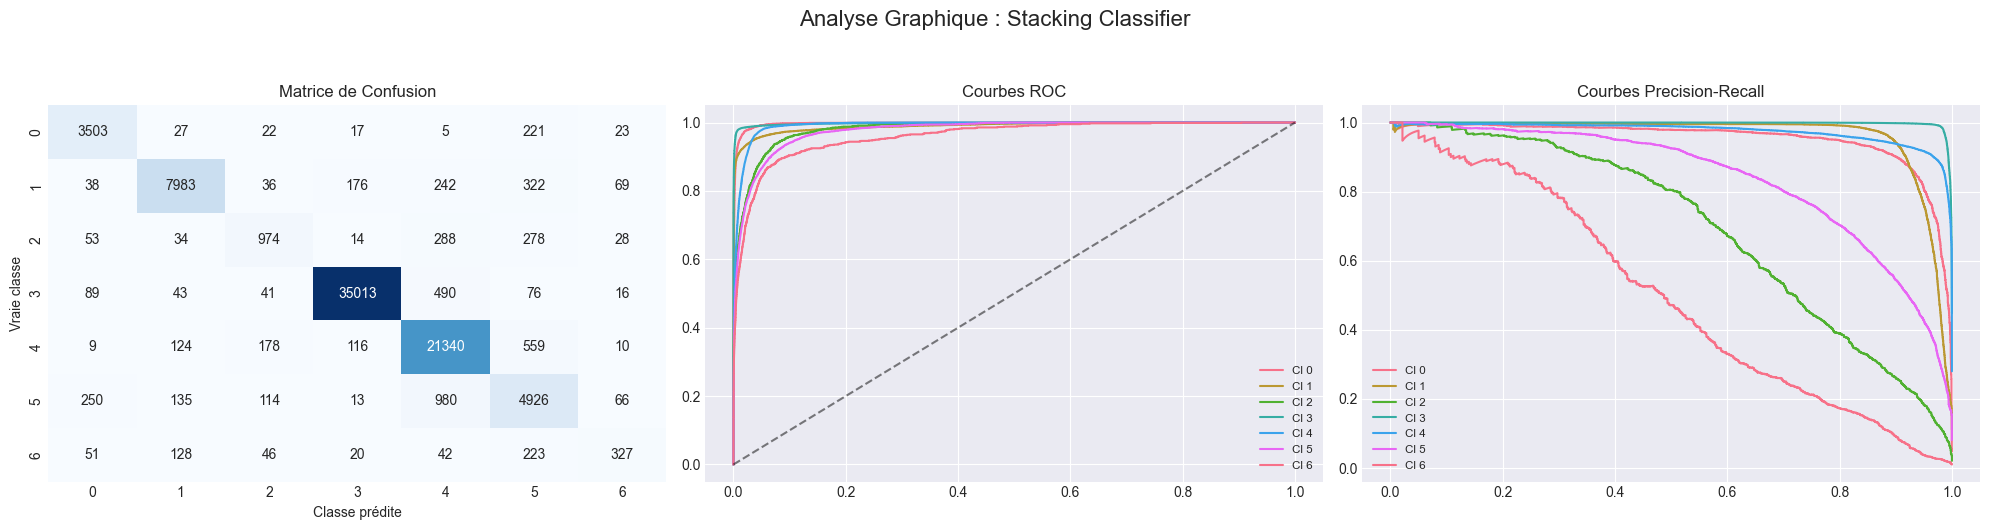


------------------------------------------------------------
🔍 COMPARAISON FINALE (Focus F1-Score)
------------------------------------------------------------
Meilleur modèle individuel (XGBoost1) F1-Score : 0.9233
Stacking Baseline F1-Score                                  : 0.9273
🚀 Le Stacking a AMÉLIORÉ le F1-Score de +0.0040

➕ MISE À JOUR DU TABLEAU DES SCORES
✅ Le modèle 'Stacking Classifier (Base)' a été ajouté à df_scores.

🏆 CLASSEMENT FINAL INCLUANT LE STACKING


,Modèle,Tuned,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps (s)
0,Stacking Classifier (Base),Non,0.928401,0.927403,0.928401,0.927332,0.992562,191.2
1,XGBoost1,Non,0.925631,0.924016,0.925631,0.923312,0.993013,13.3
2,LightGBM1,Non,0.906215,0.924071,0.906215,0.912970,0.991852,10.1
3,CatBoost1,Non,0.912357,0.910857,0.912357,0.908611,0.990133,15.5
4,RandomForest (Bagging),Non,0.889782,0.906986,0.889782,0.894279,0.988168,18.7


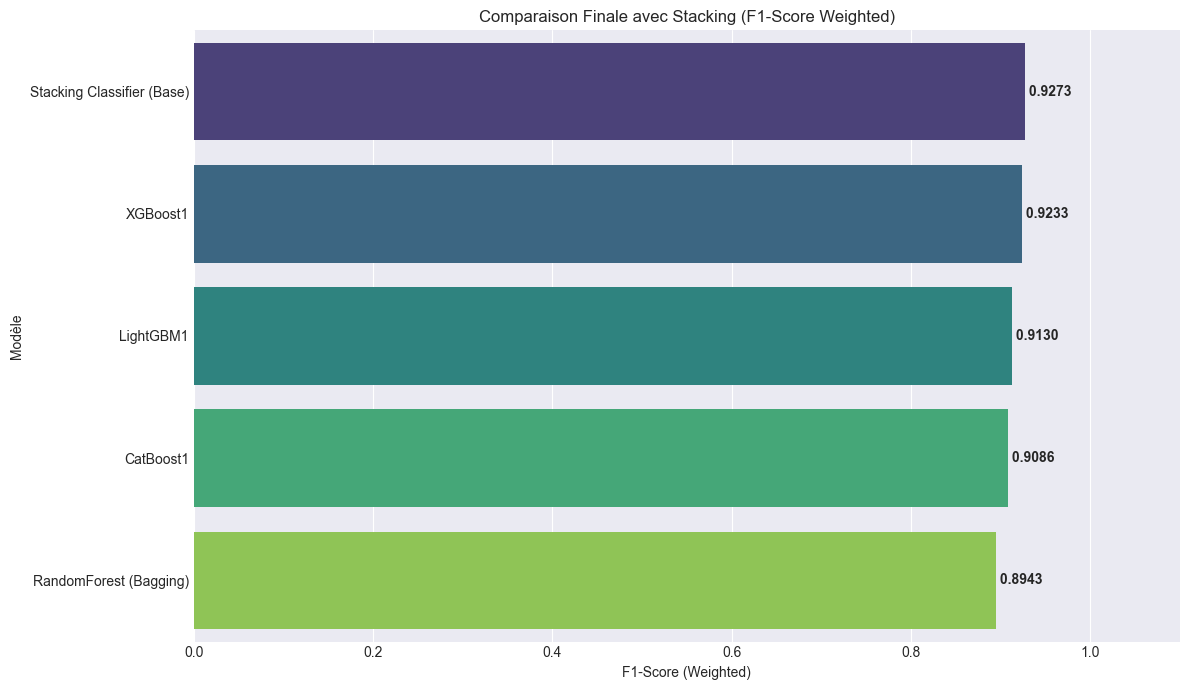

In [5]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("\n" + "="*80)
print("🏗️ 1. CONSTRUCTION ET ÉVALUATION DU STACKING BASELINE")
print("="*80)

# 1. Définition des modèles de base
estimators_base = [
    ('rf', models['RandomForest (Bagging)']),
    ('xgb', models['XGBoost1']),
    ('lgbm', models['LightGBM1']),
    ('cat', models['CatBoost1'])
]

# 2. Méta-Modèle
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# 3. Stacking Classifier
stacking_base = StackingClassifier(
    estimators=estimators_base,
    final_estimator=final_estimator,
    n_jobs=-1,
    cv=3,
    stack_method='predict_proba'
)

# 4. Entraînement
print("⏳ Entraînement du Stacking Baseline en cours...")
start = time.time()
stacking_base.fit(X_train, y_train)
stack_base_time = time.time() - start
print(f"✓ Temps d'entraînement : {stack_base_time:.2f} secondes")

# 5. Prédictions
y_pred_base = stacking_base.predict(X_test)
try:
    y_prob_base = stacking_base.predict_proba(X_test)
except AttributeError:
    y_prob_base = None

# 6. Calcul des Métriques
acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, average='weighted')
rec_base = recall_score(y_test, y_pred_base, average='weighted')
# C'est cette variable qui nous intéresse maintenant :
f1_base = f1_score(y_test, y_pred_base, average='weighted')

roc_auc_base = 0
if y_prob_base is not None:
    try:
        roc_auc_base = roc_auc_score(y_test, y_prob_base, multi_class='ovr', average='weighted')
    except Exception:
        roc_auc_base = 0

# 7. Affichage Console
print(f"\n=== RÉSULTATS : STACKING BASELINE ===")
print(f"Accuracy              : {acc_base:.4f}")
print(f"Precision (weighted)  : {prec_base:.4f}")
print(f"Recall (weighted)     : {rec_base:.4f}")
print(f"F1-score (weighted)   : {f1_base:.4f}  <-- CRITÈRE PRINCIPAL")
print(f"AUC ROC (macro OVR)   : {roc_auc_base:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_base))

# 8. VISUALISATIONS
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Analyse Graphique : Stacking Classifier", fontsize=16, y=1.05)

# Matrice
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Matrice de Confusion')
axes[0].set_xlabel('Classe prédite')
axes[0].set_ylabel('Vraie classe')

# ROC & PR (Toujours utile de les voir même si on focus sur F1)
if y_prob_base is not None:
    n_classes = y_prob_base.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_prob_base[:, i])
        axes[1].plot(fpr, tpr, label=f'Cl {i}')
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1].set_title('Courbes ROC')
    axes[1].legend(fontsize='small')

    for i in range(n_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_test == i, y_prob_base[:, i])
        axes[2].plot(recall_curve, precision_curve, label=f'Cl {i}')
    axes[2].set_title('Courbes Precision-Recall')
    axes[2].legend(fontsize='small')

plt.tight_layout()
plt.show()

# ============================================================
# 9. COMPARAISON FINALE BASÉE SUR LE F1-SCORE
# ============================================================
print("\n" + "-"*60)
print("🔍 COMPARAISON FINALE (Focus F1-Score)")
print("-" * 60)

if 'df_scores' in locals():
    # On s'assure de prendre le meilleur F1 du tableau précédent
    # (On trie à nouveau pour être sûr, au cas où l'étape précédente n'était pas triée)
    best_row = df_scores.sort_values(by="F1-Score", ascending=False).iloc[0]
    
    best_individual_score = best_row['F1-Score']
    best_individual_name = best_row['Modèle']
    
    print(f"Meilleur modèle individuel ({best_individual_name}) F1-Score : {best_individual_score:.4f}")
    print(f"Stacking Baseline F1-Score                                  : {f1_base:.4f}")
    
    diff = f1_base - best_individual_score
    
    if diff > 0:
        print(f"🚀 Le Stacking a AMÉLIORÉ le F1-Score de +{diff:.4f}")
    elif diff == 0:
        print(f"⚖️ Le Stacking a obtenu un score identique.")
    else:
        print(f"📉 Le Stacking n'a pas amélioré le F1-Score ({diff:.4f})")
else:
    print("Tableau df_scores non trouvé pour la comparaison.")

# ============================================================
# 10. AJOUT DU STACKING AU DATAFRAME df_scores
# ============================================================
print("\n" + "="*80)
print("➕ MISE À JOUR DU TABLEAU DES SCORES")
print("="*80)

# 1. Création du dictionnaire avec les résultats du Stacking
stacking_results = {
    "Modèle": "Stacking Classifier (Base)",
    "Tuned": "Non",  # C'est un stacking de modèles non-optimisés
    "Accuracy": acc_base,
    "Precision": prec_base,
    "Recall": rec_base,
    "F1-Score": f1_base,
    "ROC-AUC": roc_auc_base,
    "Temps (s)": stack_base_time
}

# 2. Ajout au DataFrame existant
if 'df_scores' in locals():
    # On transforme le dictionnaire en DataFrame
    new_row = pd.DataFrame([stacking_results])
    
    # On concatène avec le tableau existant
    df_scores = pd.concat([df_scores, new_row], ignore_index=True)
    print("✅ Le modèle 'Stacking Classifier (Base)' a été ajouté à df_scores.")
else:
    # Si df_scores n'existait pas (cas rare ici), on le crée
    df_scores = pd.DataFrame([stacking_results])
    print("⚠️ df_scores n'existait pas, il a été créé.")

# ============================================================
# 11. AFFICHAGE FINAL MIS À JOUR (Trié F1 + Couleurs)
# ============================================================
print("\n" + "="*80)
print("🏆 CLASSEMENT FINAL INCLUANT LE STACKING")
print("="*80)

# 1. Tri par F1-Score décroissant
df_scores = df_scores.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# 2. APPLICATION DU STYLE (COULEURS)
metrics_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

# Création de l'objet stylisé
styled_df = (df_scores.style
    .format({col: "{:.4f}" for col in metrics_cols})
    .format({"Temps (s)": "{:.1f}"})
    # Vert pour les bons scores
    .background_gradient(subset=metrics_cols, cmap="Greens")
    # Rouge pour le temps long
    .background_gradient(subset=["Temps (s)"], cmap="OrRd")
    .set_caption("Classement Global (Inclus Stacking)")
)

display(styled_df)

# 3. Graphique mis à jour
plt.figure(figsize=(12, 7))
sns.barplot(x="F1-Score", y="Modèle", data=df_scores, palette="viridis")

# Ajout des valeurs sur les barres
for index, value in enumerate(df_scores["F1-Score"]):
    plt.text(value, index, f' {value:.4f}', va='center', fontsize=10, fontweight='bold')

plt.title("Comparaison Finale avec Stacking (F1-Score Weighted)")
plt.xlim(0.0, 1.1)
plt.xlabel("F1-Score (Weighted)")
plt.tight_layout()
plt.show()

## 6. Optimisation des Hyperparamètres (Fine-Tuning)


🚀 DÉMARRAGE DU PROCESSUS DE FINE-TUNING

🔧 TUNING & ÉVALUATION : RandomForest (Bagging)
⏳ Recherche des meilleurs hyperparamètres (F1-Weighted)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✓ Tuning terminé en 986.2s
🏆 Meilleurs Params : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced_subsample'}

=== RÉSULTATS (TUNED) : RandomForest (Bagging) ===
Accuracy              : 0.9159
Precision (weighted)  : 0.9155
Recall (weighted)     : 0.9159
F1-score (weighted)   : 0.9126
AUC ROC (macro OVR)   : 0.9913

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.76      0.92      0.84      3818
           1       0.92      0.86      0.89      8866
           2       0.79      0.43      0.55      1669
           3       0.99      0.97      0.98     35768
           4       0.89      0.97      0.93     22336
           5       0.76      0.7

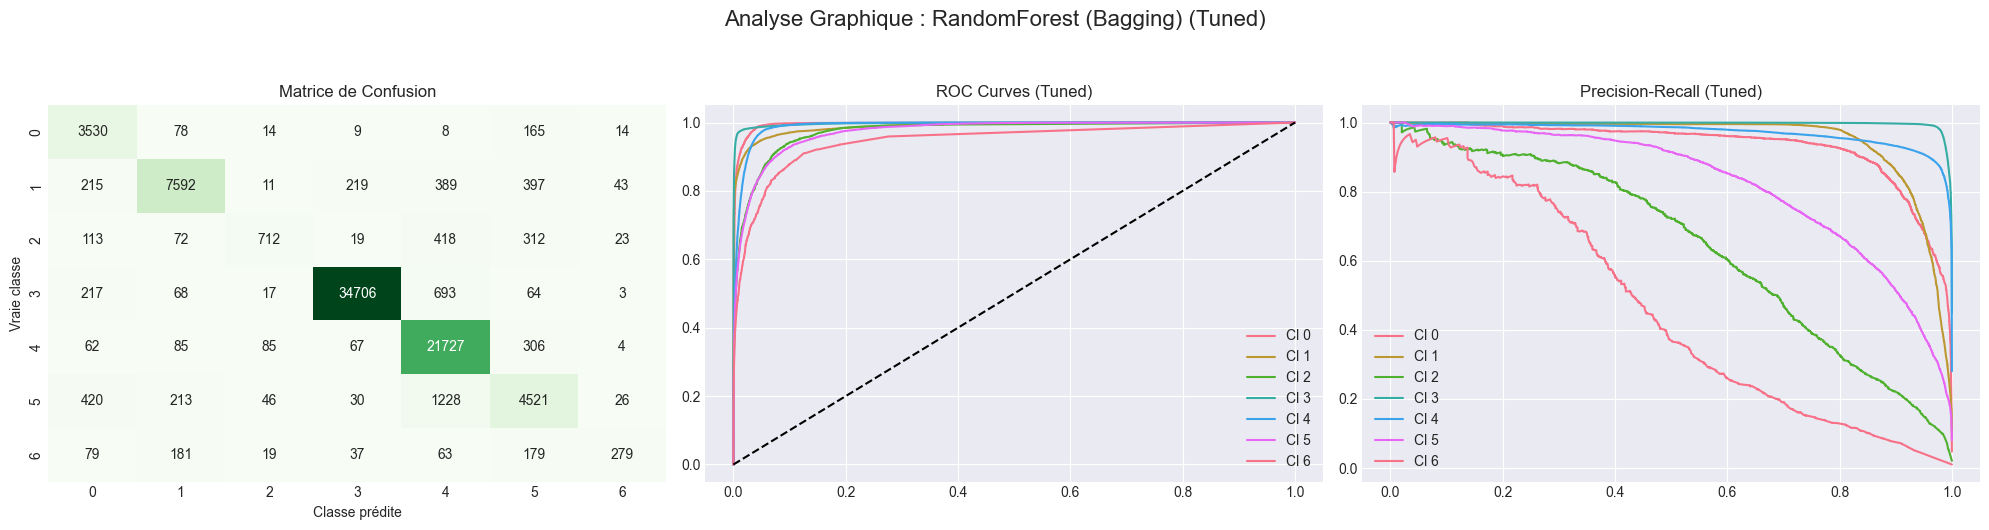


🔧 TUNING & ÉVALUATION : XGBoost1
⏳ Recherche des meilleurs hyperparamètres (F1-Weighted)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✓ Tuning terminé en 606.8s
🏆 Meilleurs Params : {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}

=== RÉSULTATS (TUNED) : XGBoost1 ===
Accuracy              : 0.9310
Precision (weighted)  : 0.9293
Recall (weighted)     : 0.9310
F1-score (weighted)   : 0.9292
AUC ROC (macro OVR)   : 0.9940

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      3818
           1       0.94      0.90      0.92      8866
           2       0.74      0.55      0.63      1669
           3       0.99      0.98      0.98     35768
           4       0.91      0.96      0.94     22336
           5       0.77      0.75      0.76      6484
           6       0.66      0.40      0.50       837


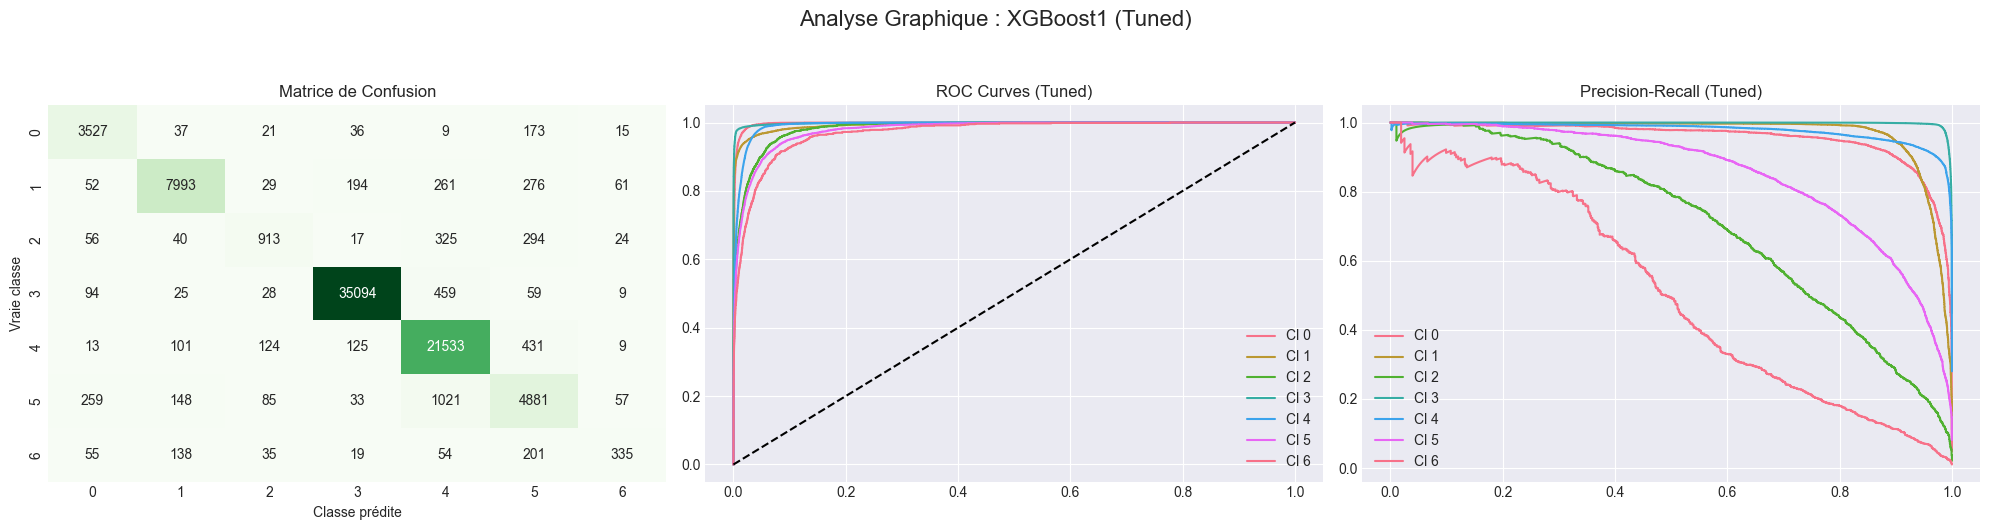


🔧 TUNING & ÉVALUATION : LightGBM1
⏳ Recherche des meilleurs hyperparamètres (F1-Weighted)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✓ Tuning terminé en 528.5s
🏆 Meilleurs Params : {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'class_weight': None}

=== RÉSULTATS (TUNED) : LightGBM1 ===
Accuracy              : 0.9313
Precision (weighted)  : 0.9296
Recall (weighted)     : 0.9313
F1-score (weighted)   : 0.9294
AUC ROC (macro OVR)   : 0.9939

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      3818
           1       0.95      0.90      0.92      8866
           2       0.73      0.55      0.63      1669
           3       0.99      0.98      0.98     35768
           4       0.91      0.97      0.94     22336
           5       0.77      0.75      0.76      6484
           6       0.6

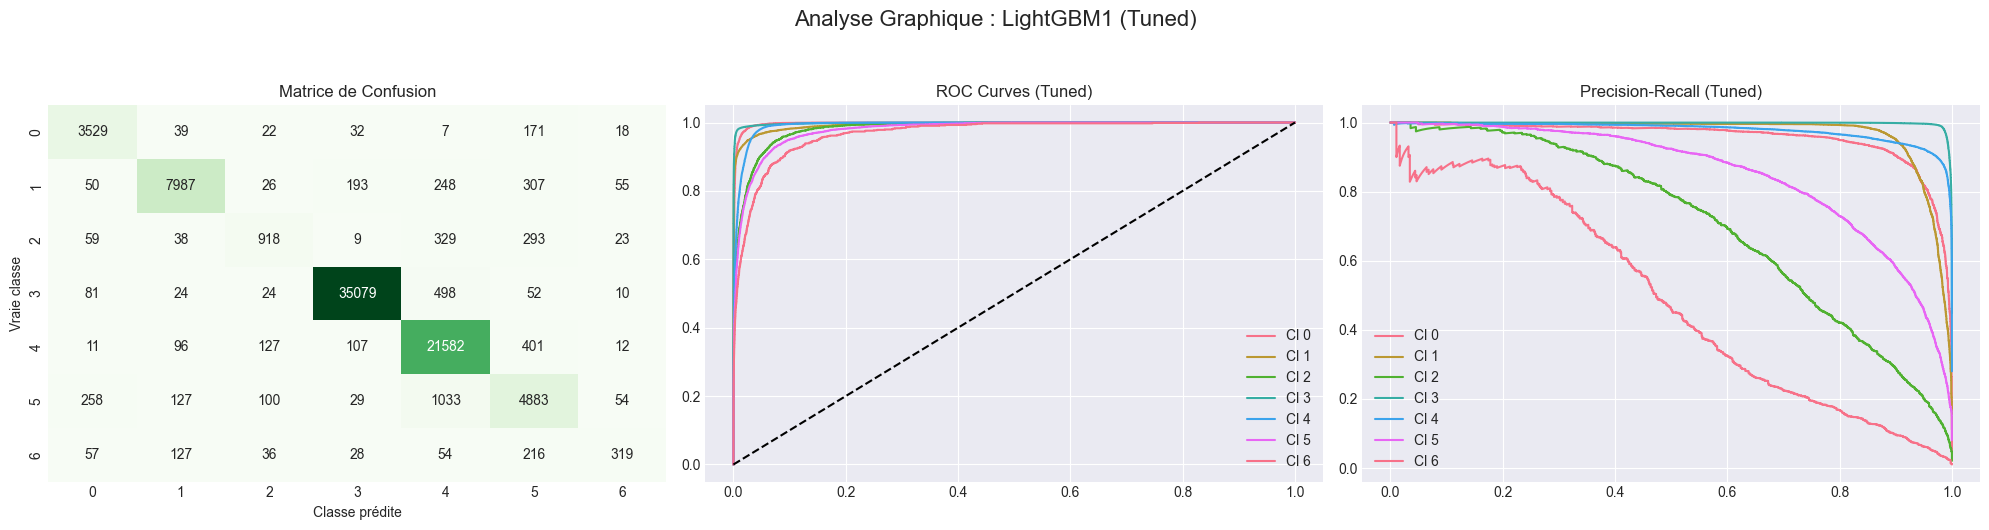


🔧 TUNING & ÉVALUATION : CatBoost1
⏳ Recherche des meilleurs hyperparamètres (F1-Weighted)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✓ Tuning terminé en 1053.5s
🏆 Meilleurs Params : {'random_strength': 2, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 10, 'auto_class_weights': 'None'}

=== RÉSULTATS (TUNED) : CatBoost1 ===
Accuracy              : 0.9261
Precision (weighted)  : 0.9242
Recall (weighted)     : 0.9261
F1-score (weighted)   : 0.9240
AUC ROC (macro OVR)   : 0.9931

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3818
           1       0.94      0.89      0.91      8866
           2       0.72      0.51      0.60      1669
           3       0.99      0.98      0.98     35768
           4       0.90      0.96      0.93     22336
           5       0.77      0.73      0.75      6484
           6       0.63      0.37      0.47       837

    accuracy

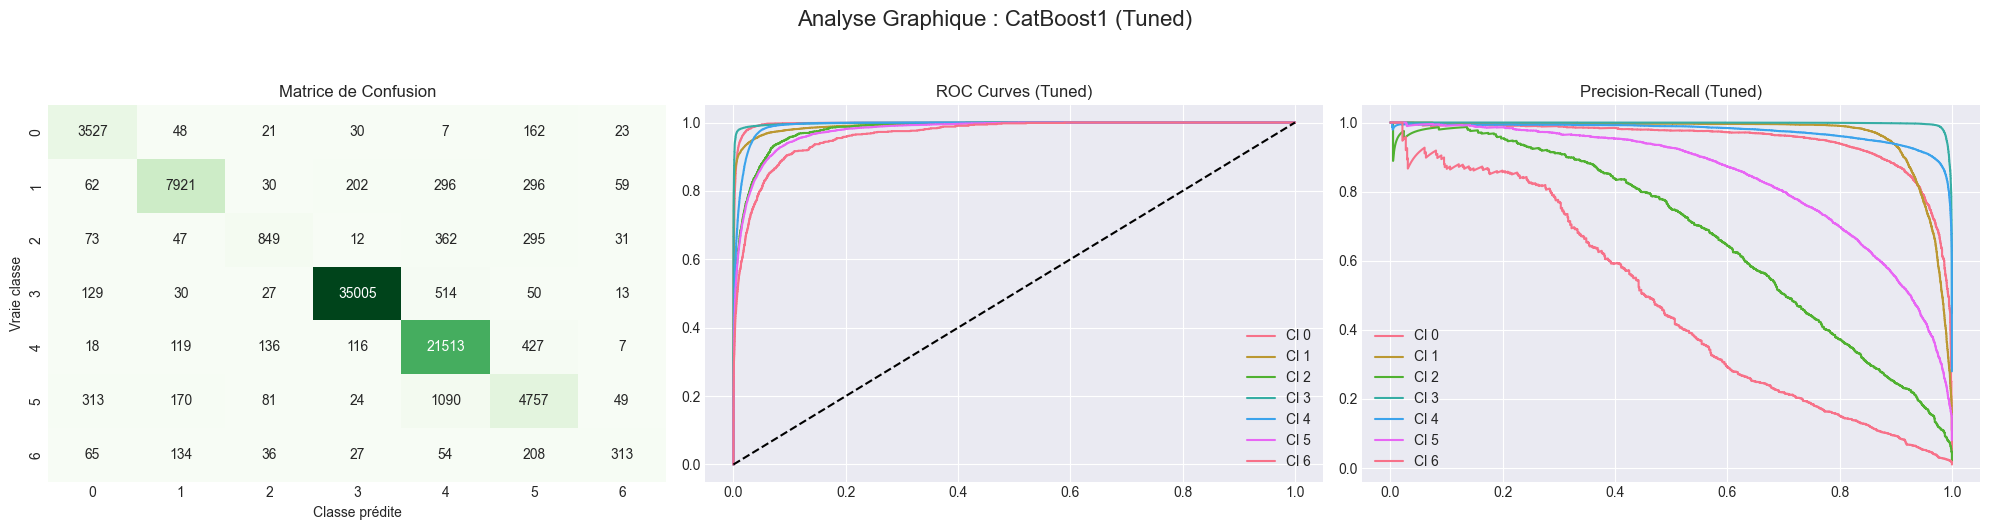


💾 ENREGISTREMENT DES RÉSULTATS TUNÉS DANS DF_SCORES
✅ 4 modèles optimisés ont été ajoutés à df_scores.
✅ Les objets modèles sont sauvegardés dans le dictionnaire 'tuned_models'.

🏆 CLASSEMENT FINAL ABSOLU (Baseline vs Stacking vs Tuned)


,Modèle,Tuned,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps (s)
0,LightGBM1 (Tuned),Oui,0.931297,0.929579,0.931297,0.929436,0.993928,528.5
1,XGBoost1 (Tuned),Oui,0.931034,0.929297,0.931034,0.929215,0.994020,606.8
2,Stacking Classifier (Base),Non,0.928401,0.927403,0.928401,0.927332,0.992562,191.2
3,CatBoost1 (Tuned),Oui,0.926133,0.924184,0.926133,0.923971,0.993051,1053.5
4,XGBoost1,Non,0.925631,0.924016,0.925631,0.923312,0.993013,13.3
5,LightGBM1,Non,0.906215,0.924071,0.906215,0.912970,0.991852,10.1
6,RandomForest (Bagging) (Tuned),Oui,0.915879,0.915492,0.915879,0.912634,0.991305,986.2
7,CatBoost1,Non,0.912357,0.910857,0.912357,0.908611,0.990133,15.5
8,RandomForest (Bagging),Non,0.889782,0.906986,0.889782,0.894279,0.988168,18.7


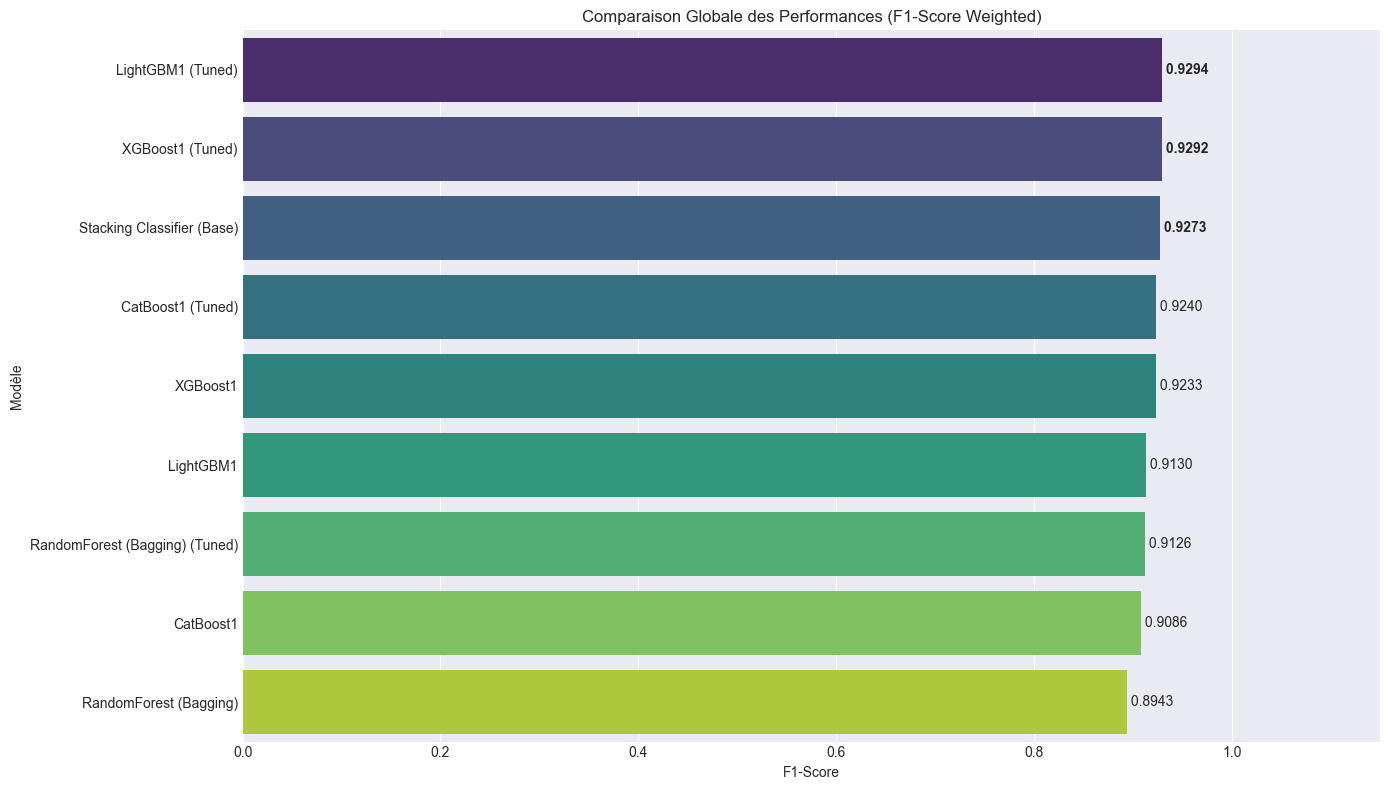

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import time

# ============================================================
# 1. DÉFINITION DES GRILLES (Hyperparameters Grid)
# ============================================================
def get_param_distributions():
    return {
        'RandomForest (Bagging)': { 
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        
        'XGBoost1': { 
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [1, 3, 5]
        },
        
        'LightGBM1': { 
            'n_estimators': [100, 200, 300],
            'max_depth': [-1, 10, 20],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [20, 31, 50, 100],
            'min_child_samples': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'class_weight': ['balanced', None]
        },
        
        'CatBoost1': { 
            'iterations': [100, 200, 300],
            'depth': [4, 6, 8, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'random_strength': [1, 2, 5],
            'auto_class_weights': ['Balanced', 'None']
        }
    }

# ============================================================
# 2. INITIALISATION DU DICTIONNAIRE DE SAUVEGARDE
# ============================================================
# C'est la variable clé qui manquait pour l'étape suivante (Stacking)
tuned_models = {} 

# ============================================================
# 3. FONCTION DE TUNING ET ÉVALUATION COMPLÈTE
# ============================================================
def tune_and_evaluate(name, model, param_dist, X_train, y_train, X_test, y_test):
    print(f"\n" + "="*80)
    print(f"🔧 TUNING & ÉVALUATION : {name}")
    print("="*80)
    
    # --- A. RandomizedSearchCV ---
    print(f"⏳ Recherche des meilleurs hyperparamètres (F1-Weighted)...")
    start_search = time.time()
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=15,                      # 15 itérations (augmentez si vous avez le temps)
        scoring='f1_weighted',          # Optimisation du F1-Score
        cv=3,                           
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    best_model = search.best_estimator_ # Le modèle optimisé
    search_time = time.time() - start_search
    
    print(f"✓ Tuning terminé en {search_time:.1f}s")
    print(f"🏆 Meilleurs Params : {search.best_params_}")

    # --- B. Prédictions sur Test Set ---
    y_pred = best_model.predict(X_test)
    try:
        y_prob = best_model.predict_proba(X_test)
    except AttributeError:
        y_prob = None

    # --- C. Calcul des Métriques ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    roc_auc_val = 0
    if y_prob is not None:
        try:
            roc_auc_val = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
        except:
            roc_auc_val = 0

    # --- D. Affichage Console ---
    print(f"\n=== RÉSULTATS (TUNED) : {name} ===")
    print(f"Accuracy              : {acc:.4f}")
    print(f"Precision (weighted)  : {prec:.4f}")
    print(f"Recall (weighted)     : {rec:.4f}")
    print(f"F1-score (weighted)   : {f1:.4f}")
    print(f"AUC ROC (macro OVR)   : {roc_auc_val:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    # --- E. Visualisations ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Analyse Graphique : {name} (Tuned)", fontsize=16, y=1.05)

    # 1. Matrice
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[0])
    axes[0].set_title('Matrice de Confusion')
    axes[0].set_ylabel('Vraie classe')
    axes[0].set_xlabel('Classe prédite')

    # 2. & 3. Courbes
    if y_prob is not None:
        n_classes = y_prob.shape[1]
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
            axes[1].plot(fpr, tpr, label=f'Cl {i}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title('ROC Curves (Tuned)')
        axes[1].legend()

        for i in range(n_classes):
            p, r, _ = precision_recall_curve(y_test == i, y_prob[:, i])
            axes[2].plot(r, p, label=f'Cl {i}')
        axes[2].set_title('Precision-Recall (Tuned)')
        axes[2].legend()

    plt.tight_layout()
    plt.show()
    
    # --- F. Retour des résultats ET du modèle ---
    stats = {
        "Modèle": f"{name} (Tuned)", 
        "Tuned": "Oui",              
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc_val,
        "Temps (s)": search_time
    }
    
    return best_model, stats # <--- IMPORTANT : On retourne le modèle ici

# ============================================================
# 4. EXÉCUTION DE LA BOUCLE DE TUNING
# ============================================================
grids = get_param_distributions()
tuned_results_list = []

print("\n🚀 DÉMARRAGE DU PROCESSUS DE FINE-TUNING")

for name, model_obj in models.items():
    if name in grids:
        # Appel de la fonction qui retourne le modèle ET les stats
        best_est, res = tune_and_evaluate(
            name, 
            model_obj, 
            grids[name], 
            X_train, y_train, X_test, y_test
        )
        
        # SAUVEGARDE DU MODÈLE POUR LE FUTUR STACKING
        tuned_models[name] = best_est
        
        # Sauvegarde des stats pour le tableau
        tuned_results_list.append(res)
    else:
        print(f"\n⏩ Pas de grille définie pour {name}, on saute.")

# ============================================================
# 5. MISE À JOUR DÉFINITIVE DE DF_SCORES
# ============================================================

print("\n" + "="*80)
print("💾 ENREGISTREMENT DES RÉSULTATS TUNÉS DANS DF_SCORES")
print("="*80)

if tuned_results_list:
    df_tuned = pd.DataFrame(tuned_results_list)
    
    # Fusion avec le DataFrame existant
    if 'df_scores' in locals():
        df_scores = pd.concat([df_scores, df_tuned], ignore_index=True)
    else:
        df_scores = df_tuned
    
    print(f"✅ {len(tuned_results_list)} modèles optimisés ont été ajoutés à df_scores.")
    print(f"✅ Les objets modèles sont sauvegardés dans le dictionnaire 'tuned_models'.")

else:
    print("⚠️ Aucun résultat de tuning n'a été trouvé.")

# ============================================================
# 6. AFFICHAGE FINAL COMPARATIF (Tout inclus)
# ============================================================
print("\n" + "="*80)
print("🏆 CLASSEMENT FINAL ABSOLU (Baseline vs Stacking vs Tuned)")
print("="*80)

# 1. Tri par F1-Score décroissant
df_scores = df_scores.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# 2. Mise en forme
metrics_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

styled_global = (df_scores.style
    .format({col: "{:.4f}" for col in metrics_cols})
    .format({"Temps (s)": "{:.1f}"})
    .background_gradient(subset=metrics_cols, cmap="Greens")
    .background_gradient(subset=["Temps (s)"], cmap="OrRd")
    .applymap(lambda v: 'font-weight: bold; color: #d62728;' if v == "Oui" else '', subset=['Tuned'])
)

display(styled_global)

# 3. Graphique Final Complet
plt.figure(figsize=(14, 8))
sns.barplot(x="F1-Score", y="Modèle", data=df_scores, palette="viridis")

for i, val in enumerate(df_scores["F1-Score"]):
    weight = 'bold' if i < 3 else 'normal' 
    plt.text(val, i, f' {val:.4f}', va='center', fontsize=10, fontweight=weight)

plt.title("Comparaison Globale des Performances (F1-Score Weighted)")
plt.xlabel("F1-Score")
plt.xlim(0, 1.15)
plt.tight_layout()
plt.show()

## 7. Stacking Avancé et CLASSEMENT DÉFINITIF


🏗️ 2. CONSTRUCTION ET ENTRAÎNEMENT DU STACKING OPTIMISÉ (Tuned)
✅ 4 modèles tunés prêts pour le stacking.
⏳ Entraînement du Stacking (Tuned) en cours...
✅ Entraînement terminé en 485.0 secondes.

=== RÉSULTATS : STACKING (TUNED) ===
Accuracy              : 0.9330
Precision (weighted)  : 0.9313
Recall (weighted)     : 0.9330
F1-score (weighted)   : 0.9312
AUC ROC (macro OVR)   : 0.9928

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3818
           1       0.94      0.91      0.92      8866
           2       0.75      0.57      0.64      1669
           3       0.99      0.98      0.99     35768
           4       0.91      0.96      0.94     22336
           5       0.78      0.76      0.77      6484
           6       0.69      0.38      0.49       837

    accuracy                           0.93     79778
   macro avg       0.85      0.78      0.81     79778
weighted avg       0.93      0.93     

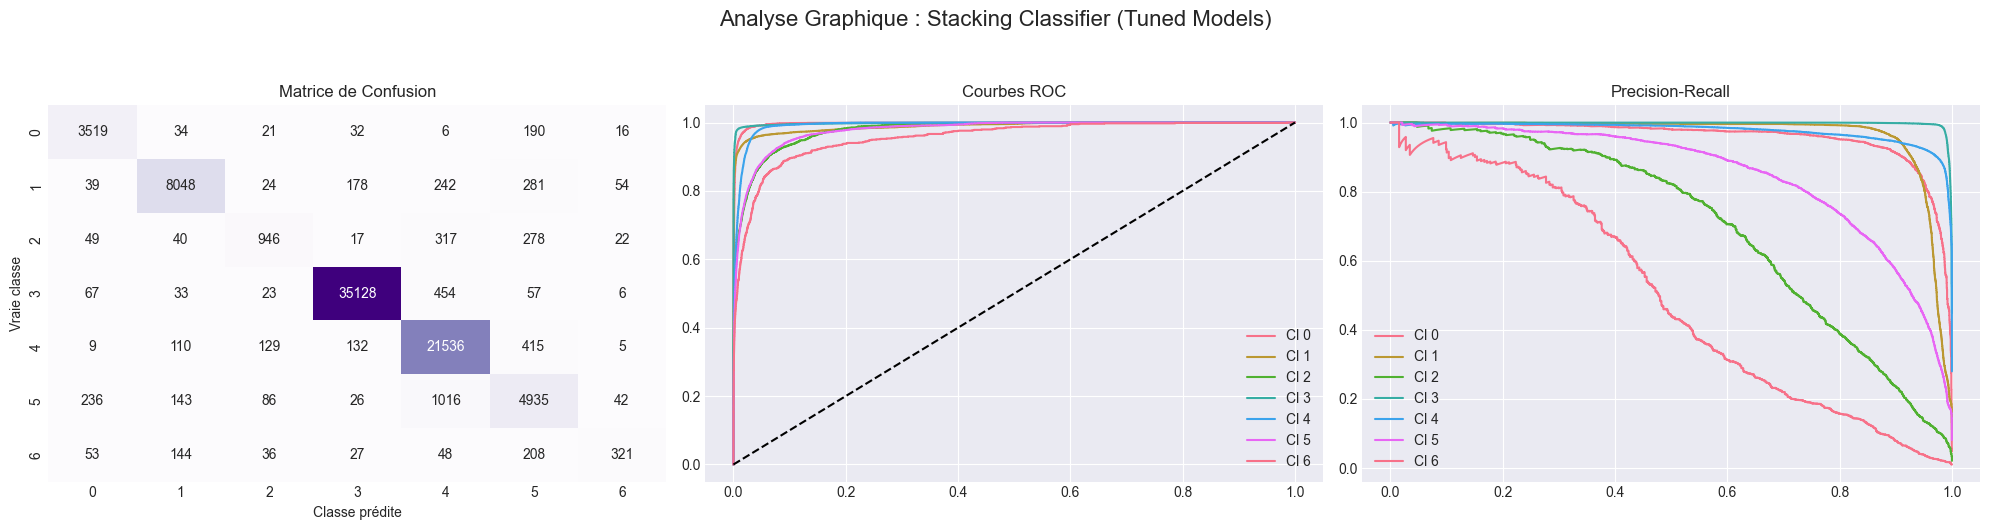


🏆 CLASSEMENT FINAL ULTIME (Inclus Stacking Tuned)


,Modèle,Tuned,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps (s)
0,Stacking Classifier (Tuned),Oui,0.933002,0.931313,0.933002,0.931176,0.992813,485.0
1,LightGBM1 (Tuned),Oui,0.931297,0.929579,0.931297,0.929436,0.993928,528.5
2,XGBoost1 (Tuned),Oui,0.931034,0.929297,0.931034,0.929215,0.994020,606.8
3,Stacking Classifier (Base),Non,0.928401,0.927403,0.928401,0.927332,0.992562,191.2
4,CatBoost1 (Tuned),Oui,0.926133,0.924184,0.926133,0.923971,0.993051,1053.5
5,XGBoost1,Non,0.925631,0.924016,0.925631,0.923312,0.993013,13.3
6,LightGBM1,Non,0.906215,0.924071,0.906215,0.912970,0.991852,10.1
7,RandomForest (Bagging) (Tuned),Oui,0.915879,0.915492,0.915879,0.912634,0.991305,986.2
8,CatBoost1,Non,0.912357,0.910857,0.912357,0.908611,0.990133,15.5
9,RandomForest (Bagging),Non,0.889782,0.906986,0.889782,0.894279,0.988168,18.7


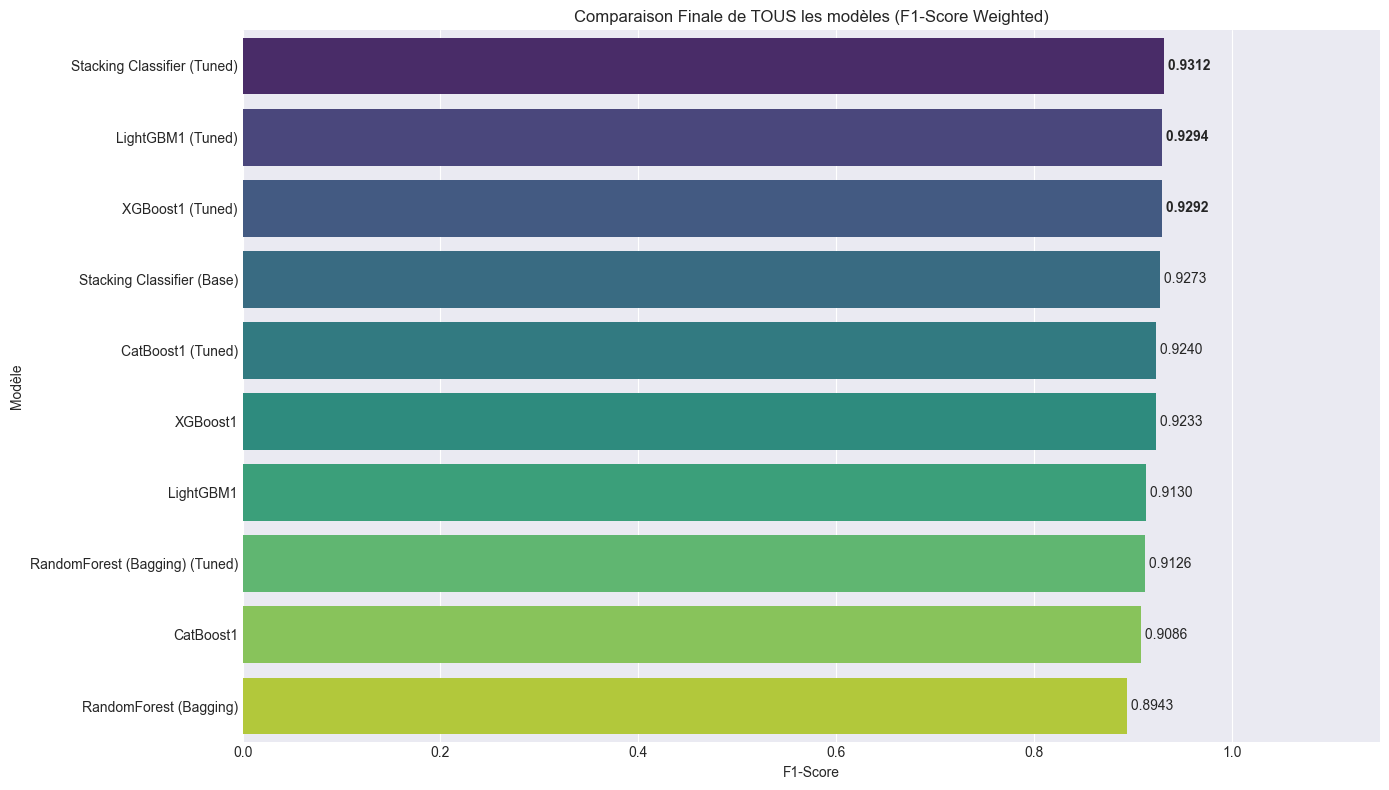

In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

print("\n" + "="*80)
print("🏗️ 2. CONSTRUCTION ET ENTRAÎNEMENT DU STACKING OPTIMISÉ (Tuned)")
print("="*80)

# 1. Définition des modèles de base (Base Learners)
# On récupère les modèles depuis le dictionnaire 'tuned_models' rempli à l'étape précédente
estimators_tuned = [
    ('rf_tuned', tuned_models.get('RandomForest (Bagging)', tuned_models.get('RandomForest'))),
    ('xgb_tuned', tuned_models.get('XGBoost1', tuned_models.get('XGBoost'))),
    ('lgbm_tuned', tuned_models.get('LightGBM1', tuned_models.get('LightGBM'))),
    ('cat_tuned', tuned_models.get('CatBoost1', tuned_models.get('CatBoost')))
]

# Filtrer les None (au cas où un modèle n'aurait pas été tuné)
estimators_tuned = [e for e in estimators_tuned if e[1] is not None]

if not estimators_tuned:
    print("❌ Erreur : Aucun modèle tuné trouvé dans 'tuned_models'.")
else:
    print(f"✅ {len(estimators_tuned)} modèles tunés prêts pour le stacking.")

    # 2. Définition du méta-modèle
    final_estimator = LogisticRegression(max_iter=2000, random_state=42)

    # 3. Création du StackingClassifier
    stacking_tuned = StackingClassifier(
        estimators=estimators_tuned,
        final_estimator=final_estimator,
        cv=3,
        stack_method='predict_proba',
        n_jobs=-1,
        passthrough=False
    )

    # 4. Entraînement
    print("⏳ Entraînement du Stacking (Tuned) en cours...")
    start_time = time.time()
    stacking_tuned.fit(X_train, y_train)
    stack_time = time.time() - start_time
    print(f"✅ Entraînement terminé en {stack_time:.1f} secondes.")

    # 5. Prédictions
    y_pred_stack = stacking_tuned.predict(X_test)
    try:
        y_prob_stack = stacking_tuned.predict_proba(X_test)
    except AttributeError:
        y_prob_stack = None

    # 6. Calcul des Métriques Détaillées
    acc_stack = accuracy_score(y_test, y_pred_stack)
    prec_stack = precision_score(y_test, y_pred_stack, average='weighted')
    rec_stack = recall_score(y_test, y_pred_stack, average='weighted')
    f1_stack = f1_score(y_test, y_pred_stack, average='weighted')
    
    roc_auc_stack = 0
    if y_prob_stack is not None:
        try:
            roc_auc_stack = roc_auc_score(y_test, y_prob_stack, multi_class='ovr', average='weighted')
        except Exception as e:
            print(f"⚠️ Erreur calcul AUC: {e}")

    # 7. Affichage Console
    print(f"\n=== RÉSULTATS : STACKING (TUNED) ===")
    print(f"Accuracy              : {acc_stack:.4f}")
    print(f"Precision (weighted)  : {prec_stack:.4f}")
    print(f"Recall (weighted)     : {rec_stack:.4f}")
    print(f"F1-score (weighted)   : {f1_stack:.4f}")
    print(f"AUC ROC (macro OVR)   : {roc_auc_stack:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_stack))

    # 8. Visualisations (3 Graphiques)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle("Analyse Graphique : Stacking Classifier (Tuned Models)", fontsize=16, y=1.05)

    # A. Matrice de Confusion
    cm = confusion_matrix(y_test, y_pred_stack)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False, ax=axes[0]) # Violet pour le final
    axes[0].set_title('Matrice de Confusion')
    axes[0].set_ylabel('Vraie classe')
    axes[0].set_xlabel('Classe prédite')

    # B. & C. Courbes ROC et Precision-Recall
    if y_prob_stack is not None:
        n_classes = y_prob_stack.shape[1]
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test == i, y_prob_stack[:, i])
            axes[1].plot(fpr, tpr, label=f'Cl {i}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title('Courbes ROC')
        axes[1].legend()

        for i in range(n_classes):
            p, r, _ = precision_recall_curve(y_test == i, y_prob_stack[:, i])
            axes[2].plot(r, p, label=f'Cl {i}')
        axes[2].set_title('Precision-Recall')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

    # ============================================================
    # 9. AJOUT AU TABLEAU df_scores ET AFFICHAGE FINAL
    # ============================================================
    print("\n" + "="*80)
    print("🏆 CLASSEMENT FINAL ULTIME (Inclus Stacking Tuned)")
    print("="*80)

    # Création de la ligne de résultat
    stack_result = {
        "Modèle": "Stacking Classifier (Tuned)",
        "Tuned": "Oui", # C'est composé de modèles tunés
        "Accuracy": acc_stack,
        "Precision": prec_stack,
        "Recall": rec_stack,
        "F1-Score": f1_stack,
        "ROC-AUC": roc_auc_stack,
        "Temps (s)": stack_time
    }

    # Ajout à df_scores
    if 'df_scores' in locals():
        df_scores = pd.concat([df_scores, pd.DataFrame([stack_result])], ignore_index=True)
    else:
        df_scores = pd.DataFrame([stack_result])

    # Tri par F1-Score
    df_scores = df_scores.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

    # Affichage Stylisé
    metrics_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
    
    styled_final = (df_scores.style
        .format({col: "{:.4f}" for col in metrics_cols})
        .format({"Temps (s)": "{:.1f}"})
        .background_gradient(subset=metrics_cols, cmap="Greens")
        .background_gradient(subset=["Temps (s)"], cmap="OrRd")
        .applymap(lambda v: 'font-weight: bold; color: #d62728;' if v == "Oui" else '', subset=['Tuned'])
    )
    
    display(styled_final)

    # Graphique Final
    plt.figure(figsize=(14, 8))
    sns.barplot(x="F1-Score", y="Modèle", data=df_scores, palette="viridis")
    
    for i, val in enumerate(df_scores["F1-Score"]):
        weight = 'bold' if i < 3 else 'normal'
        plt.text(val, i, f' {val:.4f}', va='center', fontsize=10, fontweight=weight)
        
    plt.title("Comparaison Finale de TOUS les modèles (F1-Score Weighted)")
    plt.xlim(0, 1.15)
    plt.tight_layout()
    plt.show()